In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 5)

from sklearn.neighbors import KernelDensity
from util import util
import numpy as np
from matplotlib import pyplot as plt
import os

data_folder = os.path.join('..', 'data', 'nab')
file_name = os.path.join('realKnownCause', 'nyc_taxi.csv')
data, labels, windows = util.load_series(file_name, data_folder)

# A Formalization for Anomaly Detection

<div class=big>How do we formalize our problem?</div>

## Problem Formalization

**A possible approach: we characterize the data distribution**

If we can _estimate the probability_ of every occurring observation $x$

* We can choose a size for the car pool
* ...Then we can spot anomalies based on their _low probability_

After all, anomalies are _rare events_, by definition

> **We turn a liability into a strenght!**

## Problem Formalization

**We can check our intuition on our data**

This is (roughly) the distribution _over all the data_

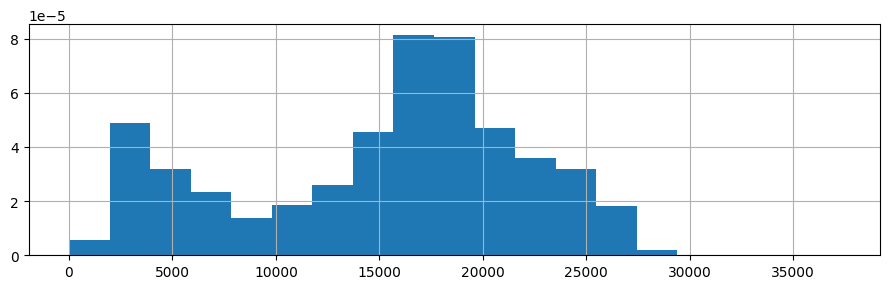

In [2]:
vmax = data['value'].max()
util.plot_histogram(data['value'], vmax=vmax, bins=20)

## Problem Formalization

**We can check our intuition on our data**

This is (roughly) the distribution _around the first anomaly_:

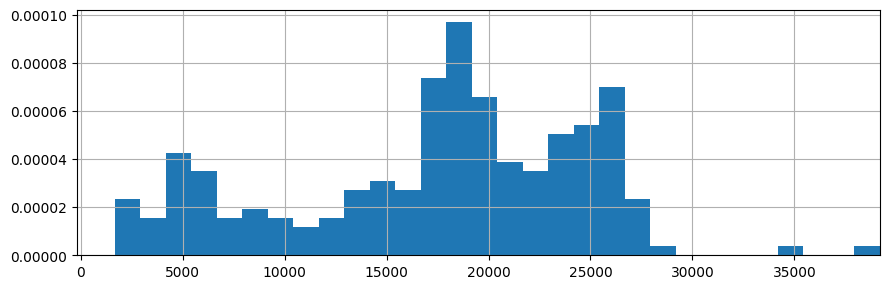

In [4]:
w0_start, w0_end = windows.loc[0]['begin'], windows.loc[0]['end']
data_anomaly0 = data[(data.index >= w0_start) & (data.index < w0_end)]
util.plot_histogram(data_anomaly0['value'], vmax=vmax, bins=30)

* It seems indeed that there's a significant difference

<div class=big>What is the next step?</div>


## Problem Formalization

**When we reach this stage, it's a good idea for _formalize_ our problem**

We can characterize a continuous distribution via its _density_

* Given a random variable $X$ with values $x$
* ...We care about its _Probability Density Function_ $f(x)$

**Since anomalies are assumed to be unlikely**

...Our detection condition can be stated as:

$$
f(x) \leq \varepsilon
$$

* Where $\varepsilon$ is a (scalar) threshold

**What do we need to make this work?**

## Density Estimation

**We need one way to _estimate probability densities_**

For some random process with n-dimensional variable $x$:

* Given the true density function $f(x): \mathbb{R}^n \rightarrow \mathbb{R}^+$
* ...And a second function $\hat{f}(x, \theta)$ with the same input, and parameters $\theta$

We want to _make the two as similar as possible_

**Can we obtain that using supervised learning?**

Given some suitable loss function $L(y, \hat{y})$, we would need to solve:

$$
\text{argmin}_{\theta} L(\hat{f}(x, \theta), f^*(x))
$$

* where $x$ represents the training data

## Density Estimation

**Unfortunately, this approach _cannot work_**

...Because typically _we do not have access_ to the true density $f^*$

> **Density estimation is an _unsupervised_ learning problem**

**It can be solved via a number of techniques:**

* Simple histograms
* Kernel Density Estimation
* Gaussian Mixture Models
* [Normalizing Flows](https://arxiv.org/abs/1505.05770)
* [Non Volume Preserving (NVP) transformations](https://arxiv.org/abs/1605.08803)

**Which one shall we pick?**

## Our Friend, Occam's Razor

**We will go with Occam's razor**

It's a philosophical principle stating that:

> **Between two hypotheses, the simpler one is usually correct**

<center><img src="assets/dt980102dhc0.gif" width="800px"/></center>

## Our Friend, Occam's Razor

**We will go with Occam's razor**

It's a philosophical principle stating that:

> **Between two hypotheses, the simpler one is usually correct**

**In practice, it's often a good idea to _start with a simple approach_**

* If it works well, then you have _a solution_
* If it does not, they you have _a baseline_

In both cases, you win!

**For this example, we will pick _Kernel Density Estimation_**

# Kernel Density Estimation

## Kernal Density Estimation

**In _Kernel Density Estimation (KDE)_, the main idea is that:**

* Wherever (in input space) there is a sample
* ...It's likely that there are more

So, we assume that _each training sample is the center for a density "kernel"_

**Formally, suck kernel $K(x, h)$ is just a valid PDF:**

* $x$ is the input variable (scalar or vector)
* $h$ is a parameter (resp. scalar or matrix) called _bandwidth_

Typical kernels: Gaussian, exponential, cosine, linear...

## Kernels

An example with one sample and a _Guassian_ kernel:

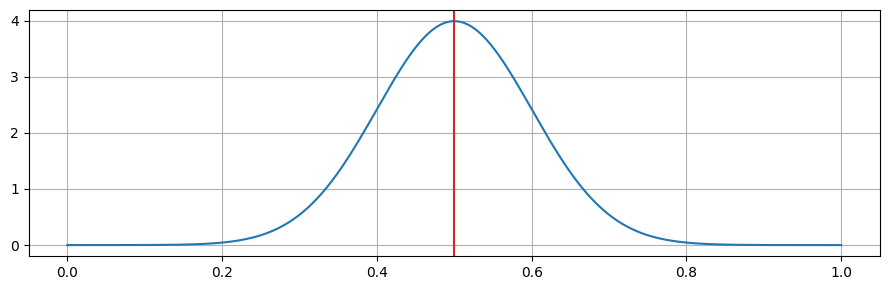

In [6]:
x = np.array(0.5).reshape(1,1) # single sample
kde = KernelDensity(kernel='gaussian', bandwidth=0.1) # build the estimator
kde.fit(x) # fit the estimator on the data
# We use a plotting function from our module
util.plot_density_estimator_1D(kde, xr=np.linspace(0, 1, 200))
ymin, ymax = plt.ylim() 
plt.vlines(x, ymin, ymax, color='tab:red')
plt.ylim((ymin, ymax)); # ; = suppress output

## Kernels

An example with one sample and a _Tophat_ kernel:

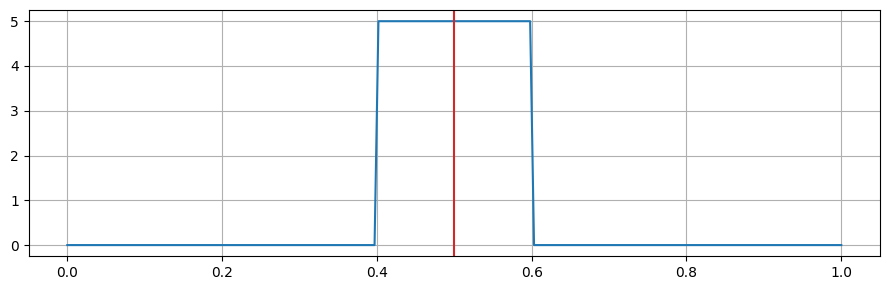

In [11]:
x = np.array(0.5).reshape(1,1) # single sample
kde = KernelDensity(kernel='tophat', bandwidth=0.1) # build the estimator
kde.fit(x) # fit the estimator on the data
# We use a plotting function from our module
util.plot_density_estimator_1D(kde, xr=np.linspace(0, 1, 200))
ymin, ymax = plt.ylim()
plt.vlines(x, ymin, ymax, color='tab:red')
plt.ylim((ymin, ymax)); # ; = suppress output

## Kernel

An example with one sample and a _linear_ kernel:

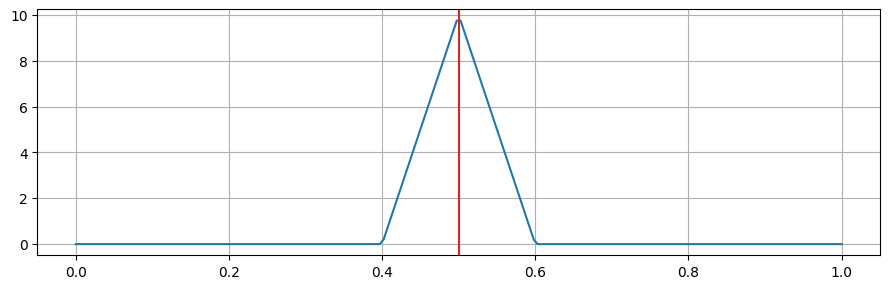

In [7]:
x = np.array(0.5).reshape(1,1) # single sample
kde = KernelDensity(kernel='linear', bandwidth=0.1) # build the estimator
kde.fit(x) # fit the estimator on the data
# We use a plotting function from our module
util.plot_density_estimator_1D(kde, xr=np.linspace(0, 1, 200))
ymin, ymax = plt.ylim()
plt.vlines(x, ymin, ymax, color='tab:red')
plt.ylim((ymin, ymax)); # ; = suppress output

## Kernels

**As an example, a _Gaussian kernel_ in sklearn is given by:**

$$
K(x, h) \propto e^{-\frac{x^2}{2h^2}}
$$

* The $\propto$ ("proportional to")

The function is similar to a the PDF of the Normal distribution:

* The mean can be interpreted as $0$
* $h$ plays the role of the standard deviation
* ...And scikit learn handles normalization

## Kernel Re-centering

**Since the "mean" is 0, the kernel is _centered on 0_**

All kernels in KDE are by default _zero-centered_

* ...But we need to place then over each sample
* How can this be done?

**We can use an _affine transformation_ (like in the scale/location trick)**

In practice, the expression:

$$
K(x - \mu, h)
$$

* ...Gives the value the value of a kernel _centered on $\mu$_
* ...Computed for the value $x$


## Kernel Density Estimation

**The estimated density of any point is obtained as a _kernel average_:**

$$
f(x, \bar{x}, h) = \frac{1}{m} \sum_{i=0}^m K(x - \bar{x}_i, h)
$$

* $x$ is the input for which we want an estimate
* $\bar{x}_i$ is sequence of the $m$ training samples
* $x - \bar{x}_i$ is the difference between $x$ and the i-th training sample

**By changing the kernel function:**

* We can adjust the properties of the distribution (e.g. smoothness)
* Typically, the choice is based on prior domain knowledge

## Kernel Density Estimation

**KDE models are not trained in the usual sense**

...But they store internally _all the training samples_

* I.e. the training set is _part of the model parameters_
* This is a property common to most kernel models

**There is one thing that we need to train, i.e. the bandwidth $h$**

* We will see a general approach later in the course
* ...But in the _univariate_ case we can apply a rule of thumb:

$$h = 0.9 \min\left(\hat{\sigma}, \frac{\mathit{IQR}}{1.34}\right) m^{-\frac{1}{5}}$$

Where $\mathit{IQR}$ is the inter-quartile range

## Kernel Density Estimation

An example with two samples and a Guassian kernel:

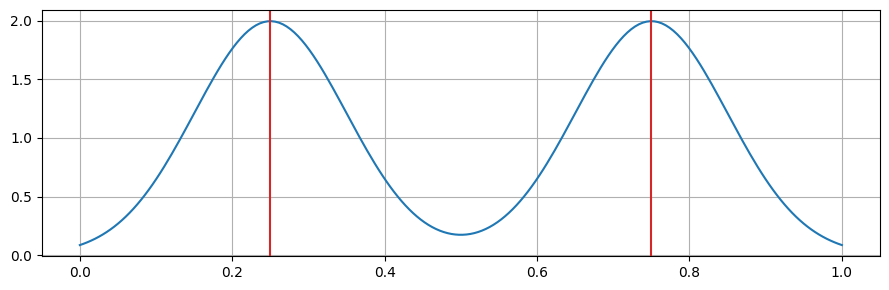

In [13]:
x = np.array([0.25, 0.75]).reshape(-1,1) # two sample, univariate
kde = KernelDensity(kernel='gaussian', bandwidth=0.1) # build the estimator
kde.fit(x) # fit the estimator on the data
util.plot_density_estimator_1D(kde, xr=np.linspace(0, 1, 200))
ymin, ymax = plt.ylim()
plt.vlines(x, ymin, ymax, color='tab:red')
plt.ylim((ymin, ymax)); # ; = suppress output